In [3]:
import os
import numpy as np

import sys

In [4]:
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import torch
import pydicom
from scipy.ndimage import zoom
from skimage.transform import radon, rescale, iradon

def get_vvbp(img_gt,num_angles,filter='ramp'):

    vvbp_tensor = np.zeros((num_angles,img_gt.shape[0],img_gt.shape[0]))

    theta_in = np.linspace(0., 180., num_angles, endpoint=False)
    sinogram_in = radon(img_gt, theta=theta_in,circle=False)
    for i in range(0,num_angles):
        # plt.imshow(iradon(sinogram_in[:,i:i+1],theta=[theta_in[i]],filter_name='ramp')),plt.show()
        recon = iradon(sinogram_in[:,i:i+1],theta=[theta_in[i]],filter_name=filter)
        vvbp_tensor[i]=recon[(recon.shape[0]-256)//2:(recon.shape[0]+256)//2,(recon.shape[0]-256)//2:(recon.shape[0]+256)//2] 
    return vvbp_tensor

In [38]:
class ct_dataset(Dataset):
    def __init__(self, pat_list = ['L067',  'L109',  'L143' , 'L192', ' L286' , 'L310'], zoom=0.5,
                pat_dir = '/egr/research-slim/maliakal/AAPM_Low_Dose_Train/Training_Image_Data/1mm B30/',
                num_angles=32,filter_name='ramp',sort_v=False
                ):
        
        self.dir = pat_dir
        self.pat_list = pat_list
        self.num_angles= num_angles
        self.img_dir = []
        self.sorted=sort_v
        self.zoom = zoom
        self.filter_name = filter_name
        for k in self.pat_list:
            print(k)
            for j in sorted(os.listdir(pat_dir+'/'+k),key = lambda s:s.split('.')[-2])[::10]:
                self.img_dir += [self.dir+'/'+k+'/'+j]

    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self,idx):
        # for img in sorted(os.listdir(p),key = lambda s:s.split('.')[-2])[:]:
        image = pydicom.dcmread(self.img_dir[idx]).pixel_array
        im2 = zoom(image,zoom=0.5).astype(np.float32)
        # plt.imshow(im2),plt.show()
        raw_n = torch.Tensor(get_vvbp(im2,self.num_angles,filter_name=self.filter_name))[np.newaxis,...]#.sum(axis=0)

        mult_factor = im2.max()/raw_n.sum(dim=1).max()
        
        return torch.Tensor(im2)[np.newaxis,...],raw_n*mult_factor,self.img_dir[idx]

class ct_dataset_2D(ct_dataset):
    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self,idx):

        image = pydicom.dcmread(self.img_dir[idx]).pixel_array
        im2 = zoom(image,zoom=0.5).astype(np.float32)
        # plt.imshow(im2),plt.show()
        raw_n = torch.Tensor(get_vvbp(im2,self.num_angles,filter=self.filter_name)).sum(axis=0)[np.newaxis,...]

        mult_factor = im2.max()/raw_n.max()
        # mult_factor = 1
        raw_n[raw_n<0] = 0 
        return torch.Tensor(im2)[np.newaxis,...],raw_n*mult_factor,self.img_dir[idx]
    


In [39]:
dataset = ct_dataset_2D(pat_list = ['L067',  'L109',  'L143' , 'L192', 'L286' , 'L310'], zoom=0.5,
                pat_dir = '/egr/research-slim/maliakal/AAPM_Low_Dose_Train/Training_Image_Data/1mm B30/',
                num_angles=32,filter_name='ramp',sort_v=False)



L067
L109
L143
L192
L286
L310


torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
/egr/research-slim/maliakal/AAPM_Low_Dose_Train/Training_Image_Data/1mm B30//L067/L067_FD_1_1.CT.0001.0001.2015.12.22.18.09.40.840353.358074219.IMA


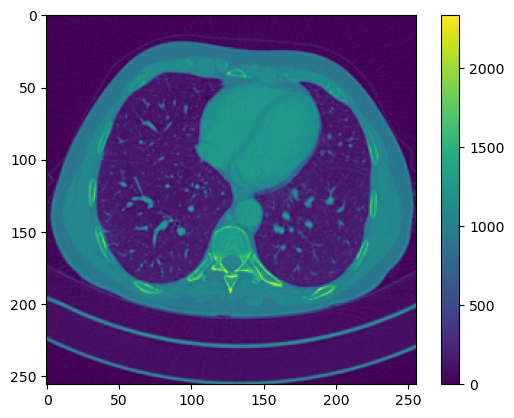

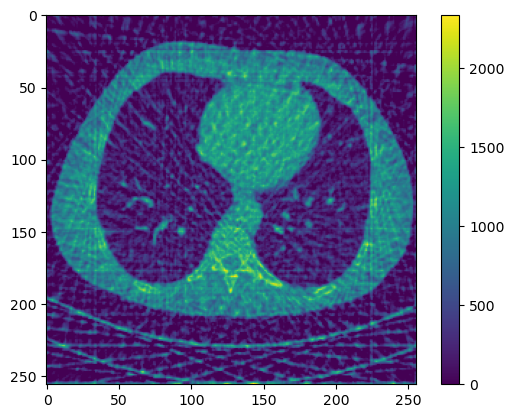

In [40]:
import matplotlib.pyplot as plt
for img, raw_n, name in dataset:
    print(img.size())
    print(raw_n.size())
    print(name)
    plt.imshow(img.squeeze()),plt.colorbar(),plt.show()
    plt.imshow(raw_n.squeeze()),plt.colorbar(),plt.show()

    break

In [41]:
def get_vvbp(img_gt,num_angles,filter_name='ramp',sorted=False):

    vvbp_tensor = np.zeros((num_angles,img_gt.shape[0],img_gt.shape[0]))

    theta_in = np.linspace(0., 180., num_angles, endpoint=False)
    sinogram_in = radon(img_gt, theta=theta_in,circle=False)
    for i in range(0,num_angles):
        # plt.imshow(iradon(sinogram_in[:,i:i+1],theta=[theta_in[i]],filter_name='ramp')),plt.show()
        recon = iradon(sinogram_in[:,i:i+1],theta=[theta_in[i]],filter_name=filter_name)
        vvbp_tensor[i]=recon[(recon.shape[0]-256)//2:(recon.shape[0]+256)//2,(recon.shape[0]-256)//2:(recon.shape[0]+256)//2] 
    if sorted:
        return np.sort(vvbp_tensor,axis=0)

    else:
        return vvbp_tensor

class ct_dataset(Dataset):
    def __init__(self, pat_list = ['L067',  'L109',  'L143' , 'L192', 'L286' , 'L310'], zoom=0.5,
                pat_dir = '/egr/research-slim/maliakal/AAPM_Low_Dose_Train/Training_Image_Data/1mm B30/',
                num_angles=32,filter_name='ramp',sort_v=False
                ):
        
        self.dir = pat_dir
        self.pat_list = pat_list
        self.num_angles= num_angles
        self.img_dir = []
        self.sorted=sort_v
        self.zoom = zoom
        self.filter_name = filter_name
        for k in self.pat_list:
            print(k)
            for j in sorted(os.listdir(pat_dir+'/'+k),key = lambda s:s.split('.')[-2])[::10]:
                self.img_dir += [self.dir+'/'+k+'/'+j]

    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self,idx):
        # for img in sorted(os.listdir(p),key = lambda s:s.split('.')[-2])[:]:
        image = pydicom.dcmread(self.img_dir[idx]).pixel_array
        im2 = zoom(image,zoom=0.5).astype(np.float32)
        # plt.imshow(im2),plt.show()
        raw_n = torch.Tensor(get_vvbp(im2,self.num_angles,filter_name=self.filter_name,sorted=self.sorted))[np.newaxis,...]

        mult_factor = im2.max()/raw_n.sum(dim=1).max()
        
        return torch.Tensor(im2)[np.newaxis,...],raw_n*mult_factor,self.img_dir[idx]



In [42]:
b = ct_dataset(filter_name='none')

L067
L109
L143
L192
L286
L310


In [ ]:
for img,n,name in ct_dataset:
    print(img.size())

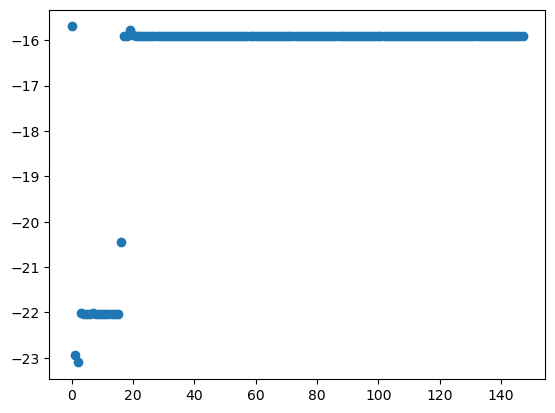

(<matplotlib.collections.PathCollection at 0x7f68eea08e50>, None)

In [12]:
import numpy as np 
l=[-6577172.035937497, -9111551475.540234, -10792317190.4, -3665380140.8, -3698866943.9999995, -3681248507.200001, -3683482344.7999997, -3657858215.9999995, -3672932239.1999993, -3695627094.4000006, -3700946568.000001, -3695220212.8, -3687108876.0000005, -3696788899.1999993, -3701790557.599999, -3702296063.2000003, -758527138.3093749, -8149579.465625001, -8067295.665625001, -7118110.643750002, -7902013.775, -8062807.112499997, -8048144.899999999, -8053583.61875, -8045997.434375, -8048646.7625, -8060258.459375001, -8051911.456250001, -8045264.221875, -8054874.975, -8057107.581250001, -8066426.19375, -8055919.53125, -8052666.793750001, -8048862.034374998, -8051397.440625001, -8048693.346875, -8047844.184375001, -8050413.425, -8050487.840625001, -8047043.2875000015, -8064729.103125003, -8056877.0874999985, -8054786.5687500015, -8056932.378125, -8056281.853125001, -8052054.425000002, -8051441.106249998, -8054393.587499999, -8050985.249999997, -8052602.500000001, -8049924.271875001, -8056742.540625001, -8061196.628124999, -8054422.768750001, -8048091.6187499985, -8054714.762499999, -8056492.725, -8054099.959375001, -8056399.546875001, -8056379.312499999, -8058016.78125, -8056976.512500001, -8058703.474999999, -8054455.6968749985, -8063103.159375002, -8049108.237499999, -8060142.531250002, -8051568.746875, -8060071.240625, -8056632.440624999, -8061101.575, -8060081.43125, -8048543.637500001, -8055076.837500001, -8057116.678124999, -8062916.44375, -8061572.437499999, -8047004.775, -8042935.862500001, -8049868.071875002, -8047411.9, -8054776.678125002, -8056889.246875, -8057065.8656250015, -8055956.931249999, -8054848.824999999, -8055749.871874999, -8052402.240624999, -8041133.850000001, -8052159.637500001, -8050778.756249999, -8053949.909375001, -8054414.934374998, -8046823.315625002, -8046930.700000001, -8063385.346875002, -8047055.009375, -8059897.887500001, -8057231.437500001, -8052660.312499999, -8066052.85625, -8060432.434374998, -8044744.553125, -8053674.137499998, -8052071.056250001, -8052340.781249998, -8058375.824999998, -8055515.821875001, -8057497.078125001, -8049298.4624999985, -8054483.4625, -8050041.534375003, -8046309.478125001, -8051061.915625002, -8048674.396875, -8051520.937500002, -8057329.562499999, -8053885.43125, -8055854.08125, -8049723.534374998, -8049647.031249999, -8047823.024999999, -8052065.546874999, -8055890.834375, -8058525.984375001, -8057792.353125002, -8045032.871875, -8048268.293749999, -8046343.762500001, -8056949.1625000015, -8050708.128124999, -8050177.393750001, -8050596.843749998, -8045783.609375001, -8061679.725000001, -8067064.418749999, -8053275.156250002, -8057714.140625002, -8051154.246874999, -8060958.343749998, -8048564.553125, -8056389.8374999985, -8061170.8343750015, -8047785.596874999, -8054991.759375001, -8047679.362500001, -8047125.1499999985]
l1 = np.arange(0,len(l))
plt.scatter(l1,[np.log(k) if k >0 else -np.log(-k) for k in l ]),plt.show()

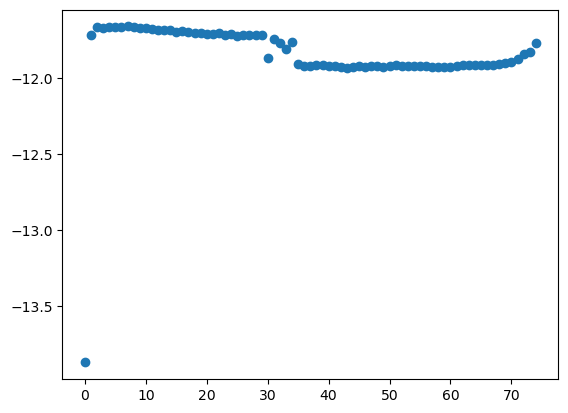

(<matplotlib.collections.PathCollection at 0x7f68eeabff40>, None)

In [14]:
l=[-1055608.826204427, -122241.12302652997, -116079.81806538899, -117036.15151367187, -116509.96046956377, -116260.16660970057, -116129.48811035154, -115865.33752441405, -116314.63673502604, -116781.54066975912, -117247.78863525392, -117603.81611735026, -118669.66534016925, -118830.43705647784, -118864.3562052409, -120253.65978597006, -119384.73908284502, -120533.64224853516, -121186.92000325523, -121290.56449584961, -121465.65873285929, -121576.23551432294, -121251.33639933268, -122647.04322509769, -121589.71485392252, -123164.12420247393, -122802.43066813149, -122660.85407714847, -122685.92627766926, -122574.11752115886, -142569.70625, -125941.28230387371, -129557.26110839845, -134583.84361979167, -128668.16444600422, -148482.60228474933, -149942.62676188155, -149924.36227569586, -149227.70300191245, -149691.84914245608, -150478.49255371094, -150342.9814188639, -150762.205645752, -152041.50000356042, -151015.01447550455, -150621.7602376302, -151024.10236409507, -150023.53745524093, -150697.34947306308, -151570.45432942713, -150724.34697062176, -149011.1184183756, -150087.96835123698, -150658.08140055335, -150376.7181111653, -150707.0455118815, -150562.13263346354, -150814.84943847655, -151295.02233886716, -151740.85890274053, -151683.8493815104, -150576.34239095057, -149715.87749023436, -148825.7685221354, -149037.8173177083, -149031.11499430338, -148796.40140380868, -149444.07983398435, -148601.4592285156, -147322.72880452476, -146319.48475748696, -143824.1637084961, -139213.55624593096, -137140.20885416667, -129517.81779988603]
l1 = np.arange(0,len(l))
plt.scatter(l1,[np.log(k) if k >0 else -np.log(-k) for k in l ]),plt.show()

In [20]:
class Agent(object):
    def __init__(self):
        a = 0
    def action(self):
        return np.random.randint(high=4,low=0)



# --------------------
# 0  1  2  3 
# 4  5  6  7
# 8  9 10 11
# 12 13 14 15


class GridWorld(object):
    def __init__(self):
        self.action_numbers = action_numbers = [1,4,-1,-4] # right, down, left, up
        
        self.state_nums =state_nums = np.arange(0,64)

        self.transition_map = {} # (action,state):(reward,next state)
        self.opt_action_map = {k:[0.25]*4 for k in self.state_nums} # state : optimal action

        for i in range(0,len(self.action_numbers)):
            for j in range(0,len(self.state_nums)):
                if action_numbers[i]==1:
                    self.transition_map[(action_numbers[i],state_nums[j])] =(-1,
                                                                              max(1,min(action_numbers[i] + state_nums[j],
                                                                                  state_nums[j] + (4-state_nums[j]%4) - 1))
                                                                            )
                if action_numbers[i]==-1:
                    self.transition_map[(action_numbers[i],state_nums[j])] =(-1,
                                                                              max(action_numbers[i] + state_nums[j],
                                                                                  state_nums[j] - (state_nums[j]%4))
                                                                            )
                
                if action_numbers[i]==4:
                    self.transition_map[(action_numbers[i],state_nums[j])] =(-1,
                                                                              min(action_numbers[i] + state_nums[j],
                                                                                  4*3 + state_nums[j]%4)
                                                                            )

                if action_numbers[i]==-4:
                    self.transition_map[(action_numbers[i],state_nums[j])] =(-1,
                                                                              max(action_numbers[i] + state_nums[j],
                                                                                  state_nums[j]%4)
                                                                            )
                final_state = self.transition_map[(action_numbers[i],state_nums[j])][-1]

                if final_state in [0,15]:
                    self.transition_map[(action_numbers[i],state_nums[j])][0]

        self.transition_map[(-1,1)]= (0,0)
        self.transition_map[(-4,4)]= (0,0)
        self.transition_map[(4,11)]= (0,15)
        self.transition_map[(1,14)]= (0,15)

        self.transition_map[(1,15)]= (0,15)
        self.transition_map[(4,15)]= (0,15)
        self.transition_map[(-1,15)]= (0,15)
        self.transition_map[(-4,15)]= (0,15)

        # self.transition_map = {(action_numbers[k],state_nums[i]):(-1,max(0,max(action_numbers[k]+state_nums[i],np.exp(int(np.log(state_nums[i]+1e-13)/np.log(4)))-1))) \
        #                   for i in range(0,len(state_nums)) for k in range(0,len(action_numbers))}

        self.cur = 0
        self.next = 0

        self.V = np.zeros((64))
        self.V_1 = np.zeros((64))
        
        self.thresh = 1
        self.gamma = 1
        self.policy_stable = True
        self.num_iters = 0
        self.old_action = np.zeros((len(self.state_nums)))

    def policy_eval(self,agent):
        # print('policy eval ')
        delta = np.inf
        
        while delta > self.thresh:
            delta = 0
            for s in self.state_nums[1:-1]:
                # for each state sample and action to get the immediate next state
                if self.num_iters ==0:
                    self.old_action[s] = self.action_numbers[agent.action()]
                
                action = self.old_action[s]

                (r,s2) = self.transition_map[(action,s)]
                self.V_1[s] = r + self.gamma*(self.V.copy())[s2]
                delta = max(delta,np.abs(self.V[s]-self.V_1[s2]))

                # print(s,r,s2)
                # self.disp_V()

            # print(delta)
            self.V = self.V_1
# 
        # print('policy eval finished \n')
        

    def policy_imp(self,agent):
        # print('policy imp ')
        for s in self.state_nums[1:-1]:
            
            old_action = self.old_action[s]

            Q = []
            for act in self.action_numbers:
                (r,s2) = self.transition_map[(act,s)]
                Q.append(r+self.gamma*self.V[s2])

            self.opt_action_map[s] = Q#/np.sum(np.abs(np.array(Q)))

            opt_action =  [1,4,-1,-4][np.argmax(self.opt_action_map[s])]

            # self.opt_action_maps[s][opt_action] = 1.0
            # print(old_action,opt_action)
            if opt_action!=old_action:
                self.old_action[s] = opt_action

                self.policy_stable = False
        self.num_iters+=1
        # print('policy imp finished')
        return self.policy_stable

    def disp_V(self):
        disp_arr = np.zeros((8,8))
        
        for i in range(0,8):
            for j in range(0,8):
                disp_arr[i,j] = self.V[4*i+j]

        print(disp_arr)

    def disp_A(self):
        disp_arr = np.zeros((8,8),dtype=object)

        for i in range(0,8):
            for j in range(0,8):
                disp_arr[i,j] = str(np.where(self.opt_action_map[i*4+j]==np.max(self.opt_action_map[i*4+j]))) # np.argmax(self.opt_action_map[i*4+j])
        
        print(disp_arr)

    def policy_it(self,agent):
        flag = False        
        num_iter = 0
        while not(flag):
            self.policy_eval(agent)
            
            # print('num iter = ',num_iter)
            # print(self.opt_action_map)
            flag = self.policy_imp(agent)
    
            if num_iter%10==0:
                print(num_iter)
                self.disp_A()
                self.disp_V()

                
            num_iter+=1
            if num_iter>100:
                break


        
        


In [21]:
grid = GridWorld()

In [22]:
agent = Agent()

In [23]:
grid.policy_it(agent=agent)
[1,4,-1,-4] # right, down, left, up

0
[['(array([0, 1, 2, 3]),)' '(array([2]),)' '(array([0, 1, 2, 3]),)'
  '(array([0, 1, 2, 3]),)' '(array([3]),)' '(array([2]),)'
  '(array([0, 1, 2, 3]),)' '(array([1]),)']
 ['(array([3]),)' '(array([2]),)' '(array([0, 1, 2, 3]),)'
  '(array([1]),)' '(array([3]),)' '(array([0, 1, 2, 3]),)'
  '(array([0]),)' '(array([1]),)']
 ['(array([3]),)' '(array([0, 1, 2, 3]),)' '(array([0]),)'
  '(array([1]),)' '(array([0, 1, 2, 3]),)' '(array([0, 1, 2, 3]),)'
  '(array([0]),)' '(array([0, 1, 2, 3]),)']
 ['(array([0, 1, 2, 3]),)' '(array([0, 1, 2, 3]),)' '(array([0]),)'
  '(array([0, 1, 2, 3]),)' '(array([0, 1, 2, 3]),)'
  '(array([0, 1, 2, 3]),)' '(array([0, 1, 2, 3]),)' '(array([1, 3]),)']
 ['(array([0, 1, 2, 3]),)' '(array([0, 1, 2, 3]),)'
  '(array([0, 1, 2, 3]),)' '(array([1, 3]),)' '(array([0, 1, 2, 3]),)'
  '(array([0, 1, 2, 3]),)' '(array([0, 1, 2, 3]),)' '(array([1]),)']
 ['(array([0, 1, 2, 3]),)' '(array([0, 1, 2, 3]),)'
  '(array([0, 1, 2, 3]),)' '(array([1]),)' '(array([0, 1, 2, 3]),)'

[1, 4, -1, -4]